In [44]:
from qdisk.model import Keplerian_velocity
from qdisk.classes import FitsImage
import eDiskplot as eplot
from qdisk.utils import is_within
from qdisk.plot import ChannelMap, Map
import analysis_utils as au
from eDisk_source_dict import source_dict
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve_fft
from analysis_utils import FWHM_to_sigma
from mcmc_tools import log_prior, emcee_run_wrapper, plot_corner, plot_walker
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patheffects as pe
from astropy.visualization import ImageNormalize, AsinhStretch
%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
config = "SBLB"
line = "SO"
robust = 1.0
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
distance = source_dict[source]["distance"]
vsys = source_dict[source]["v_sys"]

imagename = au.customimagepath + au.get_image_basename(source, config, line, robust=robust)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
rmax = 5
Mstar = 1.6

image = FitsImage(imagename, xlim=(-rmax, rmax), ylim=(-rmax, rmax))
image.shift_phasecenter_toward(center_coord)
r, t = image.get_disk_coord(incl=incl, PA=PA, frame="polar")

vlos = Keplerian_velocity(r*distance, t, Mstar=Mstar, incl=incl) + vsys

In [51]:
sigma = 0.4
M0 = 1 * (r <= 2)
sigmar = 0.2
M0 = np.exp(- r ** 2 / (2*sigmar**2))

modelcube = M0 / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2))

kernel = Gaussian2DKernel(x_stddev=FWHM_to_sigma(image.bmaj)/image.dpix, y_stddev=FWHM_to_sigma(image.bmin)/image.dpix, theta=np.radians(90+image.bpa))

modelcube = np.array([convolve_fft(im, kernel) for im in modelcube])

In [52]:
from qdisk.product import calculate_pvdiagram

x, y = image.get_disk_coord(incl=0.0, PA=PA, frame="cartesian")
posax, velax, diagram = calculate_pvdiagram(modelcube, x=x, y=y, v=image.v, PA=PA, rrange=(-3, 3))

Calculating PV diagram...
Done.


[(-10.000000053164555, 25.699999948240386)]

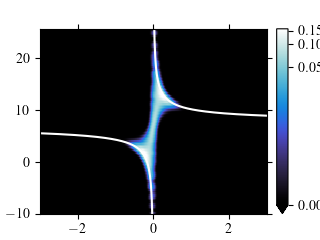

In [53]:
from qdisk.plot import PVDiagram

pvdiag = PVDiagram(diagram, posax=posax, velax=velax)
pvdiag.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0, stretch=AsinhStretch(a=0.01))
pvdiag.add_colorbar()

v_red = - Keplerian_velocity(r=pvdiag.posax[pvdiag.posax < 0]*distance, Mstar=Mstar, incl=incl) + vsys
v_blue = Keplerian_velocity(r=pvdiag.posax[pvdiag.posax > 0]*distance, Mstar=Mstar, incl=incl) + vsys

pvdiag.ax.plot(pvdiag.posax[pvdiag.posax < 0], v_red, color="white")
pvdiag.ax.plot(pvdiag.posax[pvdiag.posax > 0], v_blue, color="white")

pvdiag.ax.set(ylim=(velax.min(), velax.max()))
